# Nighttime Lights Trends in Jordan

The purpose of this notebook is to conduct an examination of the spatial and temporal distribution of artificial lights during the night across various regions in Jordan. The dataset utilized is derived from [NASA's Black Marble](https://blackmarble.gsfc.nasa.gov) and Visible Infrared Imaging Radiometer Suite (VIIRS) on the Suomi National Polar-orbiting Partnership (Suomi NPP) satellite. 

In [1]:
import math
import os
from datetime import datetime

import colorcet as cc
import dask.dataframe as dd
import matplotlib.pyplot as plt
import pandas as pd
from blackmarble.bm_extract import bm_extract
from blackmarble.bm_raster import bm_raster
from bokeh.models import ColumnDataSource, HoverTool, Legend, Range1d, Span, Text, Title
from bokeh.plotting import figure, output_notebook, show
from gadm import GADMDownloader
from matplotlib.font_manager import get_font_names

%load_ext autoreload
%autoreload 2

## Data


#### Define Region of Interest

Define region of interest for where we want to download nighttime lights data

In [2]:
ROI = GADMDownloader(version="4.0").get_shape_data_by_country_name(
    country_name="Jordan", ad_level=2
)
ROI.explore()

### Black Marble 

[NASA's Black Marble](https://blackmarble.gsfc.nasa.gov) VIIRS (Visible Infrared Imaging Radiometer Suite) Nighttime Lights dataset represents a remarkable advancement in our ability to monitor and understand nocturnal light emissions on a global scale. By utilizing cutting-edge satellite technology and image processing techniques, the Black Marble VIIRS dataset offers a comprehensive and high-resolution view of the Earth's nighttime illumination patterns.

In [3]:
dates = (
    pd.date_range("2022-01-01", "2023-11-20", freq="D").strftime("%Y-%m-%d").tolist()
)

In [4]:
# df = bm_extract(
#     roi_sf=ROI,
#     product_id="VNP46A2",
#     date=dates,
#     bearer=os.environ.get("BLACKMARBLE_TOKEN"),
#     output_location_type="file",
#     file_dir="data",
#     file_prefix="jor_",
#     aggregation_fun=["count", "mean", "min", "max", "median", "sum"],
#     quiet=True,
# )

Now that the data was acquired, let's read the data files,

In [5]:
df = dd.read_csv(
    "data/jor_VNP46A2*.csv",
    parse_dates=["date"],
).compute()
df

,ID_0,COUNTRY,NAME_1,NL_NAME_1,ID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,ntl_min,ntl_max,ntl_mean,ntl_count,ntl_sum,ntl_median,date
0,JOR,Jordan,Ajlun,,JOR.1.1_1,Ajloun,Ajlun,,Nahia,Sub-Province,,JO.AJ.AJ,26.0,28.0,27.500000,4,110.0,28.0,2022-01-01
1,JOR,Jordan,Ajlun,,JOR.1.2_1,Kofranjah,,,Nahia,Sub-Province,,JO.AJ.KF,NaN,NaN,NaN,0,NaN,NaN,2022-01-01
2,JOR,Jordan,Amman,,JOR.2.1_1,Amman,,,Nahia,Sub-Province,,JO.AM.AM,21.0,1610.0,305.159483,928,283188.0,316.0,2022-01-01
3,JOR,Jordan,Amman,,JOR.2.2_1,Jizeh,Al-Jiza,,Nahia,Sub-Province,,JO.AM.JI,0.0,1072.0,7.873661,20532,161662.0,2.0,2022-01-01
4,JOR,Jordan,Amman,,JOR.2.3_1,Mowaqqar,Al-Mwwqqar,,Nahia,Sub-Province,,JO.AM.MO,3.0,19.0,12.387755,49,607.0,12.0,2022-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47,JOR,Jordan,Tafilah,,JOR.11.2_1,Hesa,Al-Hasa,,Nahia,Sub-Province,,JO.AT.HE,NaN,NaN,NaN,0,NaN,NaN,2023-11-11
48,JOR,Jordan,Tafilah,,JOR.11.3_1,Tafileh,Al-Tafila,,Nahia,Sub-Province,,JO.AT.AT,NaN,NaN,NaN,0,NaN,NaN,2023-11-11
49,JOR,Jordan,Zarqa,,JOR.12.1_1,Azraq,Al-Azraq,,Nahia,Sub-Province,,JO.AZ.ZQ,4.0,30.0,9.016360,489,4409.0,9.0,2023-11-11
50,JOR,Jordan,Zarqa,,JOR.12.2_1,Bierain,Birin,,Nahia,Sub-Province,,JO.AZ.BR,NaN,NaN,NaN,0,NaN,NaN,2023-11-11


The latest update date is:

In [6]:
df["date"].max().strftime("%d %B %Y (Week %W)")

'11 November 2023 (Week 45)'

```{important}
The [VNP46A2 Daily Moonlight-adjusted Nighttime Lights (NTL) Product](https://blackmarble.gsfc.nasa.gov/VNP46A2.html) is [available daily](datahttps://ladsweb.modaps.eosdis.nasa.gov/missions-and-measurements/products/VNP46A2/#data-availability). However, due data quality, cloud cover or other factors, the data may not be available always at a specific location.
```

## Methodology

Creating a time series of weekly radiance using NASA's Black Marble data involves several steps, including data acquisition, pre-processing, zonal statistics calculation, and time series generation. Below is a general methodology for this process.

###  Time Series Generation

Organize the zonal statistics results in a tabular format, where each columnn corresponds to a specific zone, and rows represent the daily radiance values. Next, we aggregate the data on a weekly basis, computing the desired statistical metric (e.g., mean radiance) for each zone for each week. Finally, we will visualize the time series data to observe trends, patterns, and anomalies over time.

#### Weekly

In this step, we compute a weekly aggregation of the zonal statistics by for each second-level administrative division and for each week. In this case, we `W-SUN` and `mean` as aggregate function.

In [7]:
# https://papermill.readthedocs.io/en/latest/usage-parameterize.html
VAR = "ntl_mean"

In [8]:
JO_2 = (
    df.pivot_table(index="date", columns=["NAME_2"], values=[VAR]).resample("W").mean()
)

JO_1 = (
    df.pivot_table(index="date", columns=["NAME_1"], values=[VAR], aggfunc="mean")
    .resample("W-SUN", label="right")
    .mean()
)
JO_1

ntl_mean                                                 \
NAME_1          Ajlun       Amman      Aqaba       Balqa       Irbid   
date                                                                   
2022-01-02  24.449405  100.560509   7.354693   69.469869   34.211491   
2022-01-09  75.069969  202.476405   8.505361  134.089928  106.841876   
2022-01-16  73.258399  146.198091   7.302361  126.774726  109.848380   
2022-01-23  66.562622  206.676547  10.440221  103.589737  101.892195   
2022-01-30  50.736298  131.449640  10.701375  110.010114   92.383724   
...               ...         ...        ...         ...         ...   
2023-10-15  74.725720  268.089576  15.548408  118.383982  171.830205   
2023-10-22  77.643016  219.769259  15.844977  131.277761  182.848500   
2023-10-29  97.636910  246.901782  14.079673  149.398513  215.814159   
2023-11-05  86.800853  217.892463  14.177184  149.693422  193.366805   
2023-11-12  80.126778  226.247670  13.676275  141.766043  169.504924   

                                                                              \
NAME_1         Jarash      Karak      Ma`an     Madaba     Mafraq    Tafilah   
date                                                                           
2022-01-02  26.072344  32.249152  14.246122  35.418149  21.112632  17.448854   
2022-01-09  71.384097  27.261286  15.193569  25.749898  46.622935  21.710452   
2022-01-16  70.581380  22.452533  14.715774  26.129812  41.547182  10.761759   
2022-01-23  61.862660  28.897436  15.901350  22.496525  46.517104  20.465860   
2022-01-30  58.473055  22.605634  13.276547  19.787800  32.544107  15.558135   
...               ...        ...        ...        ...        ...        ...   
2023-10-15  79.998565  46.072971  22.191168  37.634376  59.277453  28.815367   
2023-10-22  88.222131  42.819114  23.521066  38.187475  60.871674  31.162284   
2023-10-29  93.072254  43.123620  24.703762  47.732346  55.785789  31.345070   
2023-11-05  93.819495  48.715216  22.026993  57.222549  67.613157  28.489876   
2023-11-12  83.306691  43.994994  22.184655  54.162964  56.798993  31.471792   

                        
NAME_1           Zarqa  
date                    
2022-01-02   27.433938  
2022-01-09   81.786189  
2022-01-16   68.849111  
2022-01-23   82.027899  
2022-01-30   51.250123  
...                ...  
2023-10-15   79.310402  
2023-10-22  105.373608  
2023-10-29  107.245041  
2023-11-05  109.128964  
2023-11-12   82.064807  

[98 rows x 12 columns]

Now, we visualize, 

In [9]:
data = JO_1

In [10]:
p = figure(
    title="Jordan: Weekly Nighttime Lights (2022-2023)",
    width=800,
    height=700,
    x_axis_label="Date",
    x_axis_type="datetime",
    y_axis_label=r"Radiance [nW $$cm^{-2}$$ $$sr^{-1}$$]",
    tools="pan,wheel_zoom,box_zoom,reset,save,box_select",
)
p.add_layout(
    Title(
        text=f"Weekly Adm2 Radiance Average",
        text_font_size="12pt",
        text_font_style="italic",
    ),
    "above",
)
p.add_layout(
    Title(
        text=f"Data Source: NASA Black Marble. Creation date: {datetime.today().strftime('%d %B %Y')}. Feedback: datalab@worldbank.org.",
        text_font_size="10pt",
        text_font_style="italic",
    ),
    "below",
)
p.add_layout(Legend(), "right")

p.add_tools(
    HoverTool(
        tooltips=[
            ("Week", "@x{%W} (@x{%F})"),
            ("Radiance", "@y{0.00}"),
        ],
        formatters={"@x": "datetime"},
    )
)
renderers = []
for column, color in zip(data.columns, cc.b_glasbey_category10):
    try:
        r = p.line(
            data.index,
            data[column],
            legend_label=column[1],
            line_color=color,
            line_width=2,
        )
        r.muted = True
        renderers.append(r)
    except:
        pass

renderers[0].muted = False

p.legend.location = "bottom_left"
p.legend.click_policy = "mute"
p.title.text_font_size = "16pt"
p.sizing_mode = "scale_both"

output_notebook()
show(p)

Loading BokehJS ...

```{figure} ../../docs/images/logo.png
---
height: 0px
---
Weekly average zonal statistics (i.e., `mean`) for each second-level administrative division derived from NASA Black Marble.
```

### Monthly

In this step, we compute a monthy aggregation of the zonal statistics by for each second-level administrative division and for each month. Additionaly, we add the [VNP46A3](https://ladsweb.modaps.eosdis.nasa.gov/missions-and-measurements/products/VNP46A3/#data-availability) monthly composite, when available.

In [11]:
data = (
    df.pivot_table(index="date", columns=["NAME_1"], values=[VAR], aggfunc="mean")
    .resample("MS", label="left")
    .mean()
)
data.to_csv("../../data/JOR_2-VNP46A2-M-zs.csv")

VNP46A3 = (
    dd.read_csv(
        "month/jor_VNP46A3*.csv",
        parse_dates=["date"],
    )
    .compute()
    .pivot_table(index="date", columns=["NAME_1"], values=[VAR], aggfunc="mean")
)

In [12]:
p = figure(
    title="Jordan: Monthly Nighttime Lights (2022-2023)",
    width=800,
    height=700,
    x_axis_label="Date",
    x_axis_type="datetime",
    y_axis_label=r"Radiance [nW $$cm^{-2}$$ $$sr^{-1}$$]",
    tools="pan,wheel_zoom,box_zoom,reset,save,box_select",
)
p.add_layout(
    Title(
        text=f"Monthly Adm2 Radiance (VNP46A2 and VNP46A3)",
        text_font_size="12pt",
        text_font_style="italic",
    ),
    "above",
)
p.add_layout(
    Title(
        text=f"Data Source: NASA Black Marble. Creation date: {datetime.today().strftime('%d %B %Y')}. Feedback: datalab@worldbank.org.",
        text_font_size="10pt",
        text_font_style="italic",
    ),
    "below",
)
p.add_layout(Legend(), "right")

p.add_tools(
    HoverTool(
        tooltips=[
            ("Month", "@x{%B %Y}"),
            ("Radiance", "@y{0.00}"),
        ],
        formatters={"@x": "datetime"},
    )
)
renderers = []
for column, color in zip(data.columns, cc.b_glasbey_category10):
    try:
        r = p.line(
            data.index,
            data[column],
            legend_label=column[1],
            line_color=color,
            line_width=2,
        )
        r.visible = False
        renderers.append(r)
    except:
        pass

renderers[-1].visible = True

for column, color in zip(VNP46A3.columns, cc.b_cyclic_grey_15_85_c0):
    r = p.line(
        VNP46A3.index,
        VNP46A3[column],
        legend_label=column[1] + " (VNP46A3)",
        line_color=color,
        line_width=2,
    )
    r.visible = False
    renderers.append(r)
    
renderers[-1].visible = True

p.legend.location = "bottom_left"
p.legend.click_policy = "hide"
p.title.text_font_size = "16pt"
p.sizing_mode = "scale_both"

output_notebook()
show(p)

Loading BokehJS ...

## Findings

### Percent Change in NTL Radiance

#### Baseline Comparison

In this exploratory analysis, we conducted analysis of NTL radiance trends, comparing the observed average radiance levels to a baseline established in the year 2022 for each second-level administrative division.

In [13]:
data = 100 * (
    JO_1 / JO_1[(JO_1.index >= "2022-01-01") & (JO_1.index < "2023-01-01")].mean() - 1
)

pd.set_option("display.max_rows", None)
data[data.index >= "2023-01-01"].style.map(
    lambda x: "background-color: #DF4661" if x < 0 else "background-color: white"
)

In [14]:
data.to_csv("JOR_2-VNP46A2-WSUN-percentchange.csv")

```{figure} ../../docs/images/logo.png
---
height: 0px
---
Percent change compared to a 2022 baseline. Values in red indicate a negative percent change.
```

In [15]:
p = figure(
    title="Jordan: Percent Change in Nighttime Lights Radiance",
    width=800,
    height=800,
    x_axis_label="Date",
    x_axis_type="datetime",
    y_axis_label="Radiance Percent Change (%)",
    tools="pan,wheel_zoom,box_zoom,reset,save,box_select",
)
p.xaxis.major_label_orientation = math.pi / 4
p.add_layout(
    Title(
        text=f"Percent change (compared to 2022) in NTL radiance for each second-level administrative division",
        text_font_size="12pt",
        text_font_style="italic",
    ),
    "above",
)
p.add_layout(
    Title(
        text=f"Source: NASA Black Marble. Creation date: {datetime.today().strftime('%d %B %Y')}. Feedback: datalab@worldbank.org.",
        text_font_size="10pt",
        text_font_style="italic",
    ),
    "below",
)
p.add_layout(Legend(), "right")
p.renderers.extend(
    [
        Span(
            location=datetime(2023, 10, 7),
            dimension="height",
            line_color="gray",
            line_width=1.5,
            line_dash=(4, 4),
        ),
    ]
)
p.add_tools(
    HoverTool(
        tooltips=[
            ("Week", "@x{%W} (@x{%F})"),
            ("Percent Change", "@y{0.00}% (2022 baseline)"),
        ],
        formatters={"@x": "datetime"},
    )
)
renderers = []
for column, color in zip(data.columns, cc.b_glasbey_category10):
    r = p.line(
        data.index,
        data[column],
        legend_label=str(column[1]),
        line_color=color,
        line_width=2,
    )
    r.visible = False
    renderers.append(r)

renderers[0].visible = True

p.legend.location = "bottom_left"
p.legend.click_policy = "hide"
p.title.text_font_size = "12pt"
p.sizing_mode = "scale_both"

show(p)

```{figure} ../../docs/images/logo.png
---
height: 0px
---
Percent change in average Nighttime Lights (NTL) radiance over time compared to a 2022 baseline average, with a dashed line indicating October 7th.
```

#### Week over Week Comparison

In this exploratory analysis, we conducted analysis of NTL radiance trends, comparing the observed average radiance levels week over week (WOW) for each second-level administrative division.

In [16]:
data = 100 * (JO_1.pct_change(1, axis="rows", fill_method=None))
data.to_csv("JOR_2-VNP46A2-WOW-percentchange.csv")

In [17]:
p = figure(
    title="Jordan: Percent Change in Nighttime Lights Radiance",
    width=800,
    height=800,
    x_axis_label="Date",
    x_axis_type="datetime",
    y_axis_label="Radiance Percent Change (%)",
    tools="pan,wheel_zoom,box_zoom,reset,save,box_select",
)
p.xaxis.major_label_orientation = math.pi / 4
p.add_layout(
    Title(
        text=f"Percent change week over week in NTL radiance for each second-level administrative division",
        text_font_size="12pt",
        text_font_style="italic",
    ),
    "above",
)
p.add_layout(
    Title(
        text=f"Source: NASA Black Marble. Creation date: {datetime.today().strftime('%d %B %Y')}. Feedback: datalab@worldbank.org.",
        text_font_size="10pt",
        text_font_style="italic",
    ),
    "below",
)
p.add_layout(Legend(), "right")
p.renderers.extend(
    [
        Span(
            location=datetime(2023, 10, 7),
            dimension="height",
            line_color="gray",
            line_width=1.5,
            line_dash=(4, 4),
        ),
    ]
)
p.add_tools(
    HoverTool(
        tooltips=[
            ("Week", "@x{%W} (@x{%F})"),
            ("Percent Change", "@y{0.00}% (WOW)"),
        ],
        formatters={"@x": "datetime"},
    )
)
renderers = []
for column, color in zip(data.columns, cc.b_glasbey_category10):
    r = p.line(
        data.index,
        data[column],
        legend_label=str(column[1]),
        line_color=color,
        line_width=2,
    )
    r.visible = False
    renderers.append(r)

renderers[0].visible = True

p.legend.location = "bottom_left"
p.legend.click_policy = "hide"
p.title.text_font_size = "12pt"
p.sizing_mode = "scale_both"

show(p)

```{figure} ../../docs/images/logo.png
---
height: 0px
---
Percent change in average Nighttime Lights (NTL) radiance week over week, with a dashed line indicating October 7th.
```

### National Average Weekly Radiance

In [18]:
JO_0 = JO_1.mean(axis="columns").to_frame(VAR)

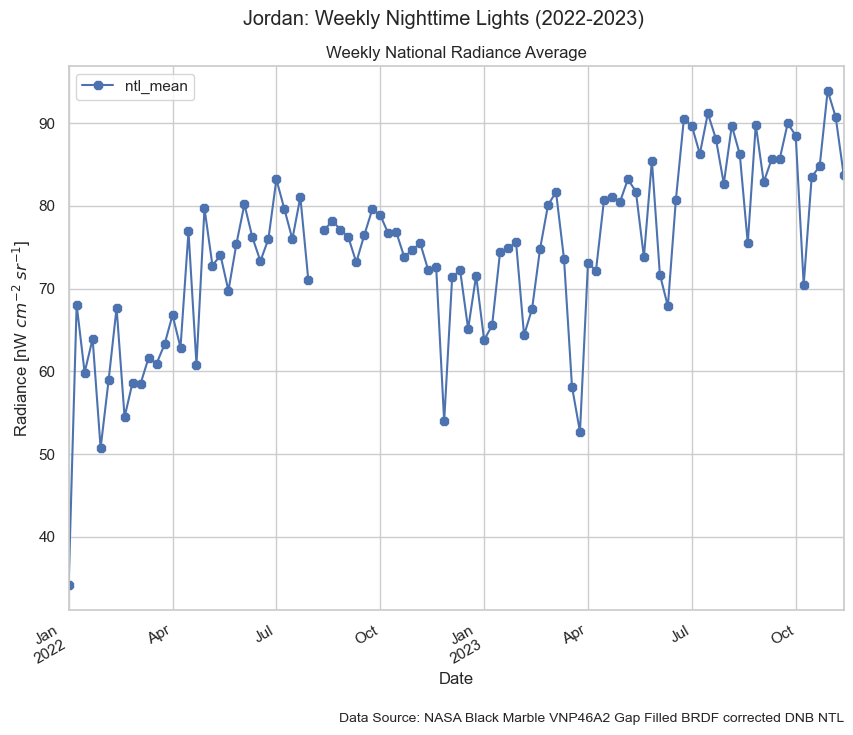

In [19]:
import matplotlib as mpl
import seaborn as sns

mpl.rcParams["font.family"] = "Arial"
sns.set_theme()
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle(f"Jordan: Weekly Nighttime Lights (2022-2023)", y=0.95)

JO_0.plot(ax=ax, marker="8")
ax.set_title("Weekly National Radiance Average")
ax.set_xlabel("Date")
ax.set_ylabel(r"Radiance [nW $cm^{-2}$ $sr^{-1}$]")
ax.ticklabel_format(style="plain", axis="y")

ax.annotate(
    "Data Source: NASA Black Marble VNP46A2 Gap Filled BRDF corrected DNB NTL",
    xy=(1.0, -0.2),
    xycoords="axes fraction",
    ha="right",
    va="center",
    fontsize=10,
)

sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
fig.autofmt_xdate()

In [20]:
fig.tight_layout()
fig.savefig("JOR_0-radiance-week-mean.png", dpi=300)

## Limitations

```{seealso}
{ref}`nighttime-lights-limitations`
```